<a href="https://colab.research.google.com/github/mansivv9/skin_cancer/blob/main/vgg_16_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#! pip install kaggle
#! mkdir ~/.kaggle
#! cp /content/kaggle.json ~/.kaggle/


In [2]:
#!kaggle datasets download -d vvmansi/256-192-dataset

In [3]:
#!unzip /content/256-192-dataset.zip

In [4]:
import os
from glob import glob
from PIL import Image

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
X_train = np.load("../input/256-192-dataset/256_192_train.npy")
y_train = np.load("../input/256-192-dataset/train_labels.npy")
X_val = np.load("../input/256-192-dataset/256_192_val.npy")
y_val = np.load("../input/256-192-dataset/val_labels.npy")

In [6]:
y_train=to_categorical(y_train)

In [7]:
y_val=to_categorical(y_val)

In [8]:
y_train.shape

(8111, 7)

In [9]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest'
        ) 
test_datagen = ImageDataGenerator() 

val_datagen = ImageDataGenerator() 


Training Without Fine-Tuning

In [10]:
pre_trained_model=tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet", input_shape=(192,256,3),classes=y_train.shape[1])

2022-04-09 03:00:30.559312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 03:00:30.759837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 03:00:30.761044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 03:00:30.764009: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

71696384/71686520 [==============================] - 2s 0us/step


In [11]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))

input_1
rescaling
normalization
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block1b_dwconv
block1b_bn
block1b_activation
block1b_se_squeeze
block1b_se_reshape
block1b_se_reduce
block1b_se_expand
block1b_se_excite
block1b_project_conv
block1b_project_bn
block1b_drop
block1b_add
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block2c_expand_

In [12]:
last_layer = pre_trained_model.get_layer('top_activation')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 6, 8, 1792)


In [13]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 192, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 192, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 193, 257, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [15]:
for layer in pre_trained_model.layers:
    layer.trainable = True
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [16]:
learning_rate_reduction = ReduceLROnPlateau( monitor='val_acc',   factor=.01,   patience=3,  min_lr=1e-5)

In [17]:
batch_size = 32
epochs = 40
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-04-09 03:00:42.075888: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18874368 exceeds 10% of free system memory.
2022-04-09 03:00:42.200649: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-04-09 03:01:03.159660: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18874368 exceeds 10% of free system memory.
2022-04-09 03:01:04.172263: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  3/253 [..............................] - ETA: 2:44 - loss: 4.5598 - acc: 0.4167  

2022-04-09 03:01:12.852057: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18874368 exceeds 10% of free system memory.


  4/253 [..............................] - ETA: 2:45 - loss: 3.9218 - acc: 0.4922

2022-04-09 03:01:13.486246: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18874368 exceeds 10% of free system memory.


  5/253 [..............................] - ETA: 2:42 - loss: 3.6695 - acc: 0.5312

2022-04-09 03:01:14.100497: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18874368 exceeds 10% of free system memory.


253/253 [==============================] - 194s 653ms/step - loss: 1.3309 - acc: 0.6341 - val_loss: 3.7582 - val_acc: 0.6652
Epoch 2/40
253/253 [==============================] - 161s 635ms/step - loss: 0.8008 - acc: 0.7054 - val_loss: 2.4797 - val_acc: 0.6629
Epoch 3/40
253/253 [==============================] - 161s 637ms/step - loss: 0.6942 - acc: 0.7542 - val_loss: 1.3536 - val_acc: 0.6685
Epoch 4/40
253/253 [==============================] - 161s 636ms/step - loss: 0.6061 - acc: 0.7761 - val_loss: 1.9747 - val_acc: 0.6618
Epoch 5/40
253/253 [==============================] - 162s 640ms/step - loss: 0.5603 - acc: 0.7975 - val_loss: 2.6149 - val_acc: 0.6696
Epoch 6/40
253/253 [==============================] - 159s 625ms/step - loss: 0.5047 - acc: 0.8138 - val_loss: 2.0432 - val_acc: 0.6674
Epoch 7/40
253/253 [==============================] - 159s 629ms/step - loss: 0.4642 - acc: 0.8298 - val_loss: 2.0492 - val_acc: 0.6663
Epoch 8/40
253/253 [==============================] - 159s 

In [18]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 [==============================] - 6s 104ms/step - loss: 0.6607 - acc: 0.8492
Validation: accuracy = 0.849224  ;  loss_v = 0.660712


In [19]:
X_test = np.load("../input/256-192-dataset/256_192_test.npy")
y_test = np.load("../input/256-192-dataset/test_labels.npy")

y_test = to_categorical(y_test)

In [20]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 3s 105ms/step - loss: 0.6814 - acc: 0.8543
Test: accuracy = 0.854291  ;  loss = 0.681419


In [21]:
model.save("EfficientNetB4.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [22]:
y_pred=model.predict_generator(X_test)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

In [24]:
K.int_shape(y_pred)

(1002, 7)

In [25]:
y_test = np.load("../input/256-192-dataset/test_labels.npy")
y_test=to_categorical(y_test)

K.int_shape(y_test)

(1002, 7)

In [26]:
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 12   2   5   0   0   0   9]
 [  2  38   8   0   6   1   2]
 [  4   0  69   0  21   1  13]
 [  1   1   1  11   1   0   0]
 [  0   1  13   0 643   0  21]
 [  0   0   0   0   1  13   0]
 [  0   0   5   2  25   0  70]]


In [27]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6']

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.63      0.43      0.51        28
     class 1       0.90      0.67      0.77        57
     class 2       0.68      0.64      0.66       108
     class 3       0.85      0.73      0.79        15
     class 4       0.92      0.95      0.94       678
     class 5       0.87      0.93      0.90        14
     class 6       0.61      0.69      0.65       102

    accuracy                           0.85      1002
   macro avg       0.78      0.72      0.74      1002
weighted avg       0.85      0.85      0.85      1002



In [29]:
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
result = sensitivity_specificity_support(y_test,y_pred,average='macro' )

print("Sensitivity: {:5.2f}%".format(100*result[0]), "specificity {:5.2f}%".format(100*result[1]))


Sensitivity: 71.87% specificity 96.17%


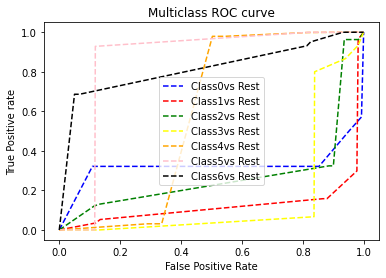

In [30]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 7

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred, pos_label=i)
    
# plotting
colors=['blue','red','green','yellow','orange','pink','black']

for i in range(0,7):
    plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i], label='Class'+ str(i) +'vs Rest')

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


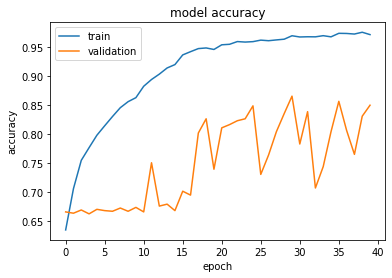

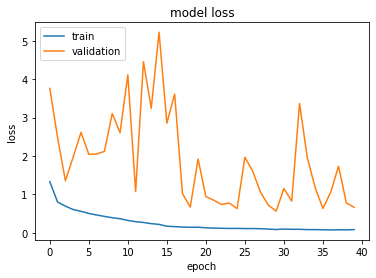

In [31]:
# summarize history for accuracy
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
#plt.plot(history.history['test_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.plot(history.history['test_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation','test'], loc='upper left')
plt.show()